In [36]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from spectral import psd

file = '/Users/ngalanis/lISA_DATA/signal/run-1/tdi-0.h5'
data  = h5py.File(file, 'r')
list(data.keys())

X2
Y2
Z2


In [3]:
keys_file = data['X2'].keys()
print("The file "+str(file)+" contains the below keys:\n")
for i in keys_file:
    print(i)

AttributeError: 'Dataset' object has no attribute 'keys'

In [4]:
test1 = data['X2']
test1_attrs = test1.attrs
print("Lets see the attribiutes")
print("------------------------------------------------------------------")
for i in test1_attrs:
    print(i+": ", test1_attrs.get(i))

Lets see the attribiutes
------------------------------------------------------------------


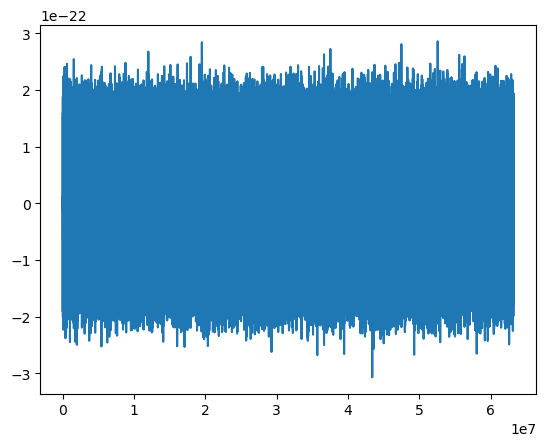

In [5]:
x2 = np.array(data['X2'])
t = np.arange(x2.size)*10

plt.plot(t[100:-100], x2[100:-100])
plt.show()

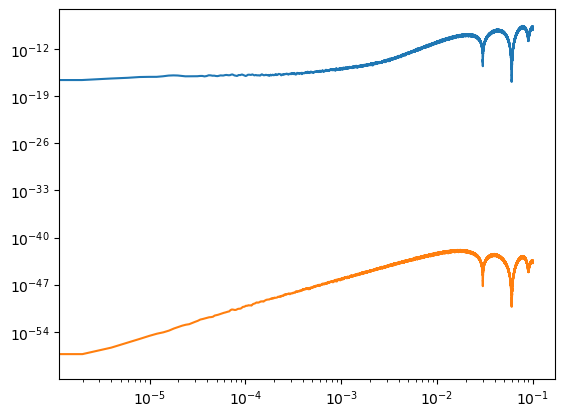

In [15]:
noise_file = '/Users/ngalanis/LISA_Data/noise/2022-12-20_16h53_noise_tdi2_5e+00s.h5'
noise = h5py.File(noise_file, 'r')

signal_file = '/Users/ngalanis/LISA_Data/signal/run-1/tdi-1.h5'
signal = h5py.File(signal_file, 'r')

x2_noise = np.array(noise['x2'])

x2_signal = np.array(signal['X2'])

f_noise, S_noise, _ = psd(x2_noise[100:-100], 0.2, nperseg = 1e5)
f_signal, S_signal, _ = psd(x2_signal[100:-100], 0.2, nperseg = 1e5)

plt.loglog(f_noise, S_noise)
plt.loglog(f_signal, S_signal)
plt.show()

In [21]:
x2_noise.shape

(6289920,)

In [28]:
wd_func = np.blackman
fs = 0.2
fmin = 1e-4
fmax = 1e-1
size_min = 100
size_max = 15000
ts = (x2_noise.size - 200)/fs
f1 = fmin - size_min/ts
f2 = fmax + size_max/ts
f_segments = frequency_grid(size_min/ts, size_max/ts, f1, f2)
fper_noise, pers_noise, segment_sizes = smooth(S_noise, fs, f_seg=f_segments)
nenbw = normalized_equivalent_noise_bandwidth(wd_func)
k_seg_noise = segment_sizes  / nenbw

In [29]:
ts = (x2_signal.size - 200)/fs
f1 = fmin - size_min/ts
f2 = fmax + size_max/ts
f_segments = frequency_grid(size_min/ts, size_max/ts, f1, f2)
fper_signal, pers_signal, segment_sizes = smooth(S_signal, fs, f_seg=f_segments)
nenbw = normalized_equivalent_noise_bandwidth(wd_func)
k_seg_signal = segment_sizes  / nenbw

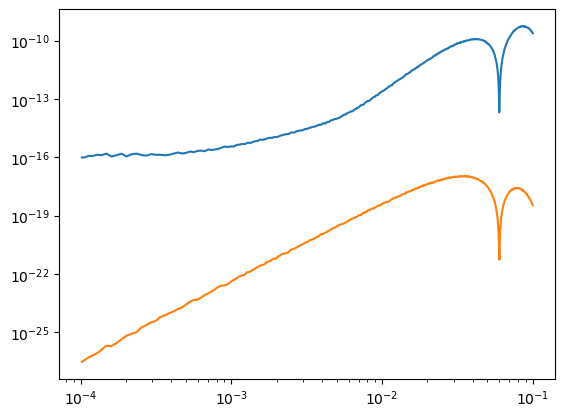

In [32]:
plt.loglog(fper_noise, pers_noise)
plt.loglog(fper_signal, 1e25*pers_signal)

In [22]:

def smooth(y, fs, f_seg, weights_func=None):
    """
    Smooth the unbiased log-periodogram data y.
    Can be either the log raw periodogram + gamma,
    or its expectation.

    Parameters
    ----------
    y : ndarray
        unbiased log-periodogram array, size n_freq x n_channels
    fs : float
        sampling frequency
    f_seg : float or ndarray
        segment frequencies

    Returns
    -------
    freqs_h : ndarray
        frequencies where the smoothed log-periodogram is computed
    p_h : ndarray
        smoothed periodogram at frequencies freqs_h
    segment_sizes : float or ndarray
        Sizes of the frequency segments

    """
    x_shape = y.shape
    freqs = np.fft.fftfreq(x_shape[0]) * fs

    # Observation duration
    t_obs = x_shape[0] / fs
    if isinstance(f_seg, float):
        # Smoothing bandwidth
        bandwidth = int(f_seg / (fs/x_shape[0]))
        # Segment frequencies
        f_seg_arr = freqs[freqs>=0][0::bandwidth]
    elif isinstance(f_seg, (np.ndarray, list)):
        f_seg_arr = np.asarray(f_seg)
    else:
        raise TypeError("f0 should be a float or array_like")
    # Number of segments
    n_seg = len(f_seg_arr)
    # Indices of the segment bounds
    i_seg = np.round(f_seg_arr * t_obs).astype(int)
    # Sizes of all intervals
    segment_sizes = i_seg[1:] - i_seg[:-1]
    # Middle frequencies
    freqs_h = (f_seg_arr[:-1] + f_seg_arr[1:]) / 2.0
    # Weighting?
    if weights_func is None:
        weights_func = np.ones

    weights_vector = [weights_func(ss) for ss in segment_sizes]

    if len(np.shape(y)) == 3:
        # Compute the averages over each segment
        p_h = np.array(
            [np.sum(y[i_seg[j]:i_seg[j+1]]*weights_vector[j][:, np.newaxis, np.newaxis], axis=0)/np.sum(weights_vector[j])
             for j in range(n_seg-1)], dtype=y.dtype)
        
    elif len(np.shape(y)) == 2:
        p_h = np.array(
            [np.sum(y[i_seg[j]:i_seg[j+1]]*weights_vector[j][:, np.newaxis], axis=0)/np.sum(weights_vector[j])
             for j in range(n_seg-1)], dtype=y.dtype)
        
    elif len(np.shape(y)) == 1:
        p_h = np.array(
            [np.sum(y[i_seg[j]:i_seg[j+1]]*weights_vector[j], axis=0)/np.sum(weights_vector[j])
             for j in range(n_seg-1)], dtype=y.dtype)
    
    return freqs_h, p_h, segment_sizes


def frequency_grid(df_min, df_max, f_min, f_max):
    """
    Produces a grid of frequencies linearly spaced, such that
    the number of Fourier bins between 2 consecutive grid frequencies 
    increases linearly as a function of frequency.

    Parameters
    ----------
    df_min : float
        minimum frequency separation between two bins
    df_max: float
        maximum frequency separation between two bins
    f_min : float
        smallest frequency of the grid
    f_max : float
        largest frequency of the grid

    Returns
    -------
    frequencies : ndarray
        frequency grid vector defining the segmentation of the Fourier space
    """
    
    # Ratio between largest segment and shortest
    alpha = df_max / df_min
    # Frequency bandwidth
    df_tot = f_max - f_min
    # Constraint on the number of grid points
    n_grid = round(2 * df_tot / (df_min + df_max))
    # Logarithmic grid for the frequency spacings
    df_grid = df_min + np.arange(0, n_grid)/(n_grid-1) * (df_max - df_min)
    # Frequency grid
    f_grid = f_min + np.cumsum(df_grid)
    
    return f_grid

def normalized_equivalent_noise_bandwidth(wd_func):
    if wd_func == np.ones:
        nenbw = 1.0
    elif wd_func == np.blackman:
        nenbw = 2.0044
    elif wd_func == np.hanning:
        nenbw = 1.5000
    elif wd_func == np.nuttal:
        nenbw = 1.9761
        
    return nenbw



In [71]:
a = np.array([[1,2,3,4],[1,3,6,8]])
print(a.swapaxes(0,1))

[[1 1]
 [2 3]
 [3 6]
 [4 8]]
